In [2]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from codvidutils.imageproc import map_categorical

# Class dataframe

In [3]:
train_class = pd.read_csv('data/train_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [4]:
test_class[test_class['class'] == 'COVID-19']

,patientID,image_path,class
5,19,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID-19
6,19,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,COVID-19
7,19,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,COVID-19
8,19,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,COVID-19
9,20,covid-19-pneumonia-15-PA.jpg,COVID-19
10,36,8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg,COVID-19
11,36,9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg,COVID-19
12,42,1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg,COVID-19
13,86,B2D20576-00B7-4519-A415-72DE29C90C34.jpeg,COVID-19
14,86,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,COVID-19


# Create an integer categorical column

In [5]:
test_class['class'].unique()

array(['pneumonia', 'COVID-19', 'normal'], dtype=object)

In [5]:
values_dict = {'pneumonia': 0, 'COVID-19': 1, 'normal': 2}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

In [6]:
test_class[test_class['class'] == 'COVID-19']

,patientID,image_path,class,class_categorical
5,19,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID-19,1
6,19,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,COVID-19,1
7,19,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,COVID-19,1
8,19,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,COVID-19,1
9,20,covid-19-pneumonia-15-PA.jpg,COVID-19,1
10,36,8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg,COVID-19,1
11,36,9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg,COVID-19,1
12,42,1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg,COVID-19,1
13,86,B2D20576-00B7-4519-A415-72DE29C90C34.jpeg,COVID-19,1
14,86,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,COVID-19,1


# Pics sets

In [8]:
train_pics = []
for img in train_class['image_path'].values:
    train_pics.append(np.array(Image.open('data/train/' + img))[:, :, :3])

In [9]:
test_pics = []
for img in test_class['image_path'].values:
    test_pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

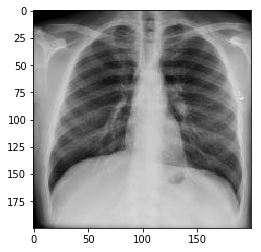

In [10]:
plt.imshow(train_pics[104])

# Neural net

In [11]:
X_train = np.array(train_pics)/255
Y_train = to_categorical(train_class['class_categorical'].values.reshape(-1, 1))
del train_class, train_pics
X_test = np.array(test_pics)/255
Y_test = to_categorical(test_class['class_categorical'].values.reshape(-1, 1))
del test_class_ test_pics
assert X_train.shape[0] == len(Y_train)
assert X_test.shape[0] == len(Y_test)
print('Train shape: {}\nTest shape: {}'.format(X_train.shape, X_test.shape))

Train shape: (16574, 200, 200, 3)
Test shape: (1953, 200, 200, 3)


In [12]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:], 
                 data_format = 'channels_last'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=20, verbose=0, validation_data=(X_test, Y_test))
pred = model.predict(X_test)
acc_train = np.average(history.history["acc"])
acc_test = np.average(history.history["val_acc"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2509056)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                80289824  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 80,291,715
Trainable params: 80,291,715
Non-trainable params: 0
_________________________________________________________________
None


8.814196615419332


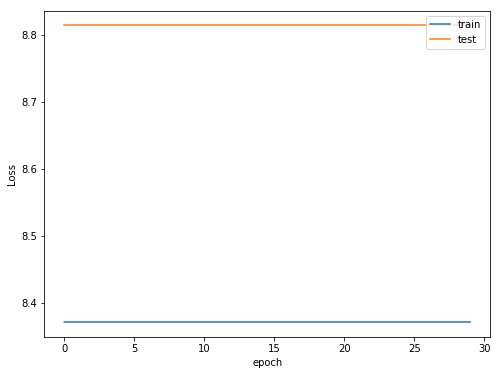

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

[Text(0,0,''),
 Text(0,0,'pneumonia'),
 Text(0,0,'CODVID-19'),
 Text(0,0,'normal')]

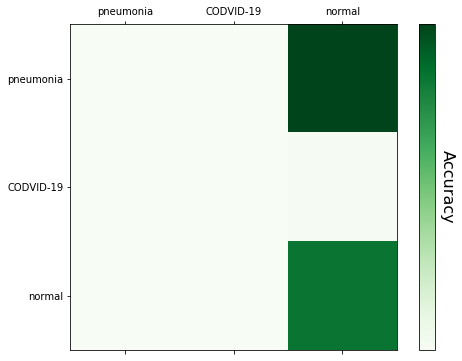

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
labels = ['pneumonia', 'CODVID-19', 'normal']
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Greens)
cbar = fig.colorbar(cax)
cbar.set_ticks([])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

In [41]:
print('max accuracy: ', round(np.max(history.history['acc']), 2))
print('{} of {} pneumonia'.format(cm[0,0], len(test_class[test_class['class'] == 'pneumonia'].values)))
print('{} of {} COVID-19'.format(cm[1,1], len(test_class[test_class['class'] == 'COVID-19'].values)))
print('{} of {} normal'.format(cm[2,2], len(test_class[test_class['class'] == 'normal'].values)))

max accuracy:  0.48
0 of 1058 pneumonia
0 of 10 COVID-19
885 of 885 normal
